In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

"""
Question 1)  Using mid-prices, find all the arbitrages in butterfly spreads with adjacent strike prices.

Question 2)  Using bid- and ask-quotes, find all the butterfly spread arbitrages.
"""

# Date: 7-Aug-2018
# Maturity: 21-Jun-2019
# Expiration: 318

# Need to convert expiration in days to expiration in years
period = 318/365

# C = S + P - K*exp(-rT)
r = -(0.0244 + 1)
stock = 379.57
forward = 387.73


In [3]:
from fractions import Fraction

def weights(low, mid, high):
    A = np.array([[low, high], [1, 1]])
    b = np.array([mid, 1])
    x = np.linalg.solve(A, b)
    f1 = Fraction(x[0]).limit_denominator().numerator
    f2 = Fraction(x[1]).limit_denominator().numerator
    return [f1, f2]

In [4]:
spread = pd.read_excel('./ButterflyHomework.xlsx', skiprows=12)
# Need to use skiprows=12 to get the proper dataframe formatting

spread.head()

,strike,Vol 8/7,Fitted Vol,Black-Scholes Call,Bid,Mid,Ask
0,55,0.957070,0.693550,326.325944,325.325944,326.325944,327.325944
1,60,0.902117,0.685908,321.378535,320.378535,321.378535,322.378535
2,65,0.851266,0.678353,316.431076,315.431076,316.431076,317.431076
3,70,0.876616,0.670885,311.858668,310.858668,311.858668,312.858668
4,75,0.758869,0.663504,306.536247,305.536247,306.536247,307.536247


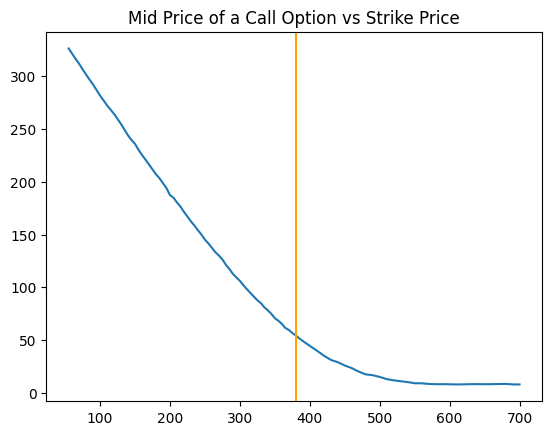

In [5]:
plt.plot(spread['strike'], spread['Mid'])
#plt.plot(spread['strike'], spread['Black-Scholes Call'])
plt.title("Mid Price of a Call Option vs Strike Price")
plt.axvline(x = stock, color = 'orange', label = 'axvline - full height')
plt.show()

# Question 1

There are 41 arbitrage opportunities, or center strike prices where the net spread of the butterfly is >0


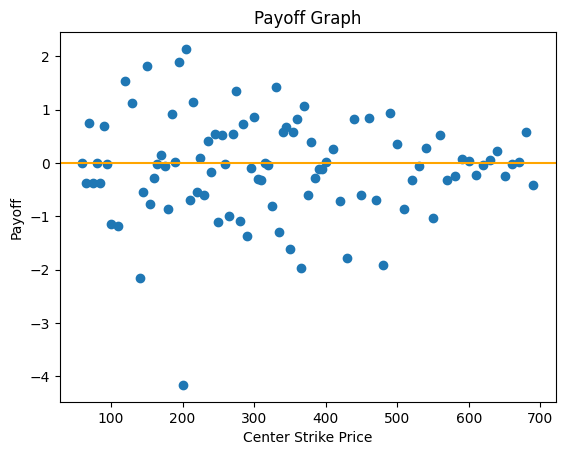

In [6]:
# This function returns the payoff of a call option, as we've learned in class
def payoff(s, k):
    return max([0, (s-k)])
counter = 0
arr = []
centerKs = []
arb = []
for index, row in spread.iterrows():
    if index > 0 and index < 95:
        coefs = weights(spread.loc[index-1]['strike'], spread.loc[index]['strike'], spread.loc[index+1]['strike'])
        a = -1 * coefs[0] * spread.loc[index-1]['Mid']
        b = np.sum(coefs) * spread.loc[index]['Mid']
        c = -1 * coefs[1] * spread.loc[index+1]['Mid']
        
        # Buy one call at lowest price, sell 2 calls at the middle price, and buy 1 call at the higher price
        #arbitrage occurs when net spread < 0
        money = a+b+c
        if (money > 0):
            centerKs.append(spread.loc[index-1]['strike'])
            arb.append(money)
            counter += 1
        arr.append(money)
print("There are " + str(counter) + " arbitrage opportunities, or center strike prices where the net spread of the butterfly is >0")
plt.scatter(spread['strike'][1:95], arr)
plt.axhline(y = 0, color = 'orange', label = 'axvline - full height')
plt.xlabel("Center Strike Price")
plt.ylabel("Payoff")
plt.title("Payoff Graph")
plt.show()

In [7]:
data = []
for i in range(0, len(arb)):
    data.append([arb[i], centerKs[i]])
q1Arbs = pd.DataFrame(data=data, columns=['Arbitrage Value', 'Center Strike Price'])
q1Arbs.head()

,Arbitrage Value,Center Strike Price
0,0.000050,55.0
1,0.750013,65.0
2,0.687472,85.0
3,1.537393,110.0
4,1.125134,120.0


# Question 2

In [8]:
import itertools
strike_prices = spread.strike

# combinations will contain all unique triples of strike prices
combinations = list(itertools.combinations(strike_prices, 3))
print("There are " + str(len(combinations)) + " unique combinations")

There are 142880 unique combinations


In [9]:
data = []
counter = 0
for combo in combinations:
    
    coefs = weights(combo[0], combo[1], combo[2])
    a = -1 * coefs[0] * spread.loc[spread['strike'] == combo[0]]['Ask'].iloc[0]
    b = np.sum(coefs) * (spread.loc[spread['strike'] == combo[1]])['Bid'].iloc[0]
    c = -1 * coefs[1] * (spread.loc[spread['strike'] == combo[2]])['Ask'].iloc[0]
    data.append([combo[0], coefs[0], combo[1], np.sum(coefs), combo[2], coefs[1], (a+b+c)])
    
final = pd.DataFrame(data=data, columns=['Low K', '# at Low K', "Middle K", "# at Middle K", "High K", "N# at High K", "Arbitrage Value"])

In [19]:
from mpl_toolkits import mplot3d
final_arbs = final.loc[(final['Arbitrage Value']) > 0]
final_arbs

,Low K,# at Low K,Middle K,# at Middle K,High K,N# at High K,Arbitrage Value
139606,430,3,440,4,470,1,0.124223
139607,430,4,440,5,480,1,0.010056
139655,430,1,460,4,470,3,0.171112
141110,480,2,490,3,510,1,0.740369
141111,480,3,490,4,520,1,0.677971
141112,480,4,490,5,530,1,0.301786
141130,480,1,500,3,510,2,0.165013
142658,580,1,680,6,700,5,0.012883
142758,600,1,680,5,700,4,0.061822
142794,610,2,680,9,700,7,0.332111


In [17]:
x = len(final.loc[(final['Arbitrage Value']) > 0])
y = len(final['Low K'])
print(
    "When we use all possible option combinations, sell at the bid, and buy at the ask, there are \n" + 
    str(x) + 
    " arbitrage opportunities, which is " + 
    str((x/y)*100) + " percent of combinations available."
)

When we use all possible option combinations, sell at the bid, and buy at the ask, there are 
11 arbitrage opportunities, which is 0.007698768197088466 percent of combinations available.


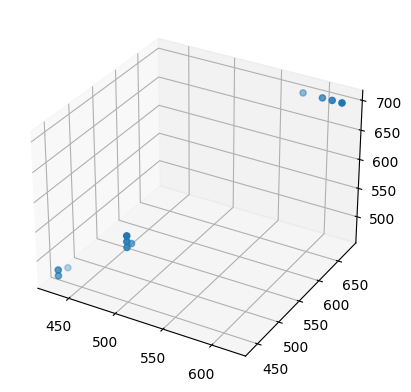

In [23]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(final_arbs['Low K'], final_arbs['Middle K'], final_arbs['High K'])